# Estimation de la latence et de la capacité d’une connexion à partir de mesures asymétriques

## Téléchargements des données

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [88]:
# Données de connexion courte à l'intérieur d'un campus
archive1_url = "http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/liglab2.log.gz"

# Données de connexion vers un site Web éloigné
archive2_url = "http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/stackoverflow.log.gz"

## Initialisation des données

In [89]:
from urllib.request import urlopen
import gzip
import re

archive = urlopen(archive1_url)
raw_data = gzip.decompress(archive.read())
lines = raw_data.decode('latin-1').strip().split('\n')

format_string = r'\[(?P<date>[\d.]+)\] (?P<size>\d+) bytes from lig-publig.imag.fr \((?P<ip_address>[·\d.]+)\): icmp_seq=(?P<icmp>\d+) ttl=(?P<ttl>\d+) time=(?P<time>[\d.]+) ms'

def extract_values(line):
    match = re.match(format_string, line)
    if match:
        return [float(match.group('date')), int(match.group("size")), match.group("ip_address"), int(match.group("icmp")), int(match.group("ttl")), float(match.group("time"))]
    else:
        return None

table = [extract_values(line) for line in lines]

Vérification de la validité des ligne et suppression des lignes inutilisables

In [90]:
non_valid_lines = [index for index in range(len(table)) if table[index] is None]

for i in non_valid_lines[::-1]:
    table.pop(i)

## Mise en forme des données

On place l'origine des temps à 0 et on utilise panda pour structurer les données.

In [91]:
start_time = table[0][0]
for line in table:
    line[0] -= start_time

data = pd.DataFrame(table, columns = ["date", "size", "IP", "icmp", "ttl", "time"])
data

date  size           IP  icmp  ttl   time
0         0.000000   665  129.88.11.7     1   60  22.50
1         0.225143  1373  129.88.11.7     1   60  21.20
2         0.449882   262  129.88.11.7     1   60  21.20
3         0.677085  1107  129.88.11.7     1   60  23.30
4         0.882476  1128  129.88.11.7     1   60   1.41
...            ...   ...          ...   ...  ...    ...
44031  9503.959738  1338  129.88.11.7     1   60   1.47
44032  9504.170557  1515  129.88.11.7     1   60   7.02
44033  9504.376835  1875  129.88.11.7     1   60   2.33
44034  9504.582575  1006  129.88.11.7     1   60   1.61
44035  9504.788050  1273  129.88.11.7     1   60   1.35

[44036 rows x 6 columns]

## 1. Évolution du temps de transmission au cours du temps

<Axes: >

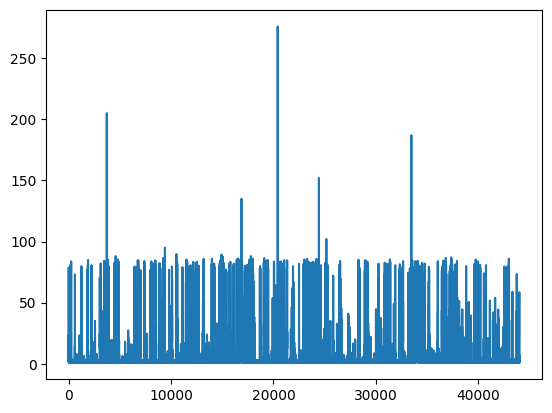

In [92]:
data['time'].plot()

Les délais de transmissions ne sont pas stable au cours du temps et ce graphique ne nous donne pas d'information sur la taille des messages.

## 2. Évolution du temps de transmission en fonction de la taille des messages

<Axes: xlabel='size', ylabel='time'>

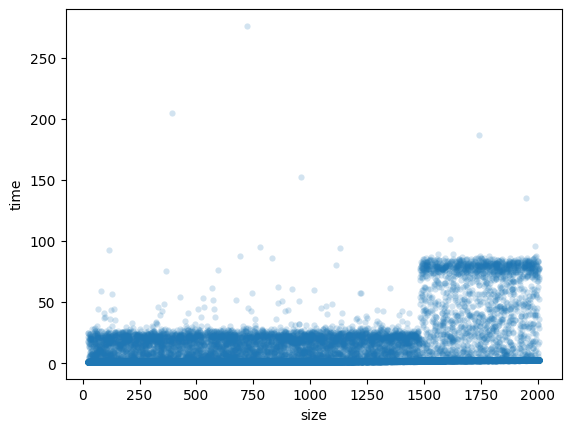

In [93]:
data.plot.scatter(x='size', y='time', alpha=0.2, lw=0)

À partir de 1500 MB de données, les messages peuvent prendre de zéro à une centaines de secondes pour être transmis. La durée de transmission ne dépasse généralement pas les 30 secondes pour des messages de taille inférieure.

On divise maintenant nos données en deux ensembles pour séparer les messages courts et les messages longs observés précédemment. Nous pouvons ensuit effectuer une regréssion linéraire du temps de transmission en fonction de la taille des messages.

Messages de petites tailles: T(S) = 3.128080832670244 + S/1620.0508339606433
Messages de grandes tailles: T(S) = 4.770226990457225 + S/349.4863964116837


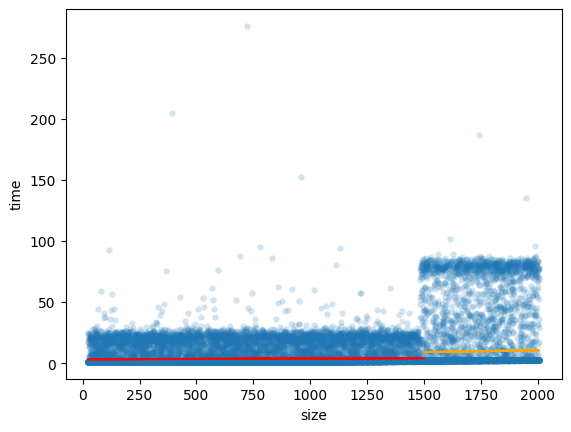

In [94]:
small_messages = data[data["size"] < 1500]
large_messages = data[data["size"] >= 1500]

from sklearn import linear_model

length_small = len(small_messages.values)
time_small = small_messages['time'].values.reshape((length_small, 1))
size_small = small_messages['size'].values.reshape((length_small, 1))

length_large = len(large_messages.values)
time_large = large_messages['time'].values.reshape((length_large, 1))
size_large = large_messages['size'].values.reshape((length_large, 1))

model = linear_model.LinearRegression()
results_small = model.fit(size_small, time_small)
model = linear_model.LinearRegression()
results_large = model.fit(size_large, time_large)

ax = data.plot.scatter(x='size', y='time', alpha=0.2, lw=0)
ax.plot(small_messages['size'].values, results_small.predict(size_small), color='red', label="T(S) = " + str(results_small.intercept_[0]) + " + s/" + str(1/results_small.coef_[0][0]))
ax.plot(large_messages['size'].values, results_large.predict(size_large), color='orange', label="T(S) = " + str(results_large.intercept_[0]) + " + s/" + str(1/results_large.coef_[0][0]))

print("Messages de petites tailles: T(S) = " + str(results_small.intercept_[0]) + " + S/" + str(1/results_small.coef_[0][0]))
print("Messages de grandes tailles: T(S) = " + str(results_large.intercept_[0]) + " + S/" + str(1/results_large.coef_[0][0]))

Les données sont dispersées, faire une régression sur l'ensemble de données n'a pas trop de sens, on effectue la mème démarche sur les plus petits temps de transmission pour chaque taille de message.

Messages de petites tailles: T(S) = 1.0184949405206583 + S/3677.3003222225725
Messages de grandes tailles: T(S) = 1.7384489775540815 + S/4066.4862115110495


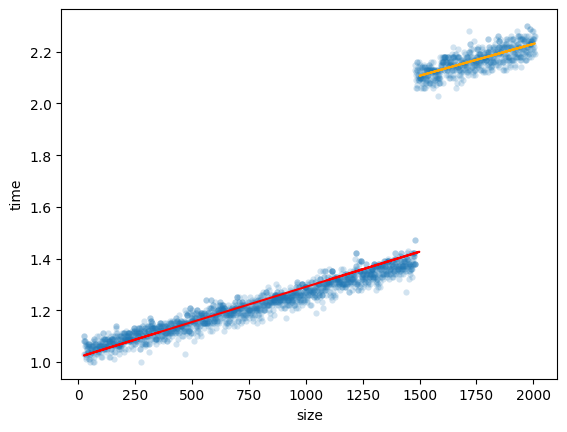

In [99]:
min_messages = data.loc[data.groupby('size')['time'].transform('min').eq(data['time'])].reset_index(drop=True)
min_small_messages = min_messages[min_messages["size"] < 1500]
min_large_messages = min_messages[min_messages["size"] >= 1500]

length_small = len(min_small_messages.values)
time_small = min_small_messages['time'].values.reshape((length_small, 1))
size_small = min_small_messages['size'].values.reshape((length_small, 1))

length_large = len(min_large_messages.values)
time_large = min_large_messages['time'].values.reshape((length_large, 1))
size_large = min_large_messages['size'].values.reshape((length_large, 1))

model = linear_model.LinearRegression()
results_min_small = model.fit(size_small, time_small)
model = linear_model.LinearRegression()
results_min_large = model.fit(size_large, time_large)

ax = min_messages.plot.scatter(x='size', y='time', alpha=0.2, lw=0)
ax.plot(min_small_messages['size'].values, results_min_small.predict(size_small), color='red', label="T(S) = " + str(results_min_small.intercept_[0]) + " + s/" + str(1/results_min_small.coef_[0][0]))
ax.plot(min_large_messages['size'].values, results_min_large.predict(size_large), color='orange', label="T(S) = " + str(results_min_large.intercept_[0]) + " + s/" + str(1/results_min_large.coef_[0][0]))

print("Messages de petites tailles: T(S) = " + str(results_min_small.intercept_[0]) + " + S/" + str(1/results_min_small.coef_[0][0]))
print("Messages de grandes tailles: T(S) = " + str(results_min_large.intercept_[0]) + " + S/" + str(1/results_min_large.coef_[0][0]))
